In [23]:
import requests
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pickle
from scipy.sparse import issparse

In [24]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\Elsayed
[nltk_data]     Hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Elsayed
[nltk_data]     Hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
# Part 1: Web Scraping using TMDb API
def fetch_tmdb_movies(api_key, max_movies=100):
    movies_data = []
    base_url = "https://api.themoviedb.org/3/discover/movie"
    params = {
        'api_key': '92e89881fee050a9add5845a3f7a8223',
        'language': 'en-US',
        'sort_by': 'popularity.desc',
        'page': 1
    }
    
    movie_count = 0
    while movie_count < max_movies:
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            print(f"Failed to fetch data from TMDb: {response.status_code}")
            break
        
        data = response.json()
        for movie in data['results']:
            if movie_count >= max_movies:
                break
            # Fetch additional details (e.g., cast, age rating)
            movie_id = movie['id']
            details_url = f"https://api.themoviedb.org/3/movie/{movie_id}"
            credits_url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits"
            details_params = {'api_key': api_key, 'language': 'en-US'}
            
            details_response = requests.get(details_url, params=details_params)
            credits_response = requests.get(credits_url, params=details_params)
            
            if details_response.status_code == 200 and credits_response.status_code == 200:
                details = details_response.json()
                credits = credits_response.json()
                
                movies_data.append({
                    'title': movie['title'],
                    'rating': movie['vote_average'],
                    'genre': ', '.join([g['name'] for g in details.get('genres', [])]),
                    'description': movie['overview'],
                    'actors': ', '.join([c['name'] for c in credits.get('cast', [])[:3]]),
                    'age_rating': details.get('release_dates', {}).get('results', [{}])[0].get('release_dates', [{}])[0].get('certification', 'N/A'),
                    'poster': f"https://image.tmdb.org/t/p/w500{movie['poster_path']}" if movie['poster_path'] else 'N/A',
                    'release_year': details.get('release_date', 'N/A')[:4]
                })
                movie_count += 1
        
        params['page'] += 1
    
    # Create DataFrame and ensure unique index
    df = pd.DataFrame(movies_data)
    df = df.drop_duplicates(subset=['title'])  # Remove duplicate titles
    df = df.reset_index(drop=True)  # Reset index to ensure uniqueness
    df.to_csv('movies_data.csv', index=False)
    return df


In [26]:
# Execute Web Scraping
print("Fetching TMDb data...")
API_KEY = '92e89881fee050a9add5845a3f7a8223'  # Replace with your TMDb API key
movies_df = fetch_tmdb_movies(API_KEY, max_movies=100)

Fetching TMDb data...


In [27]:
print(movies_df.isnull().sum())
print(movies_df.duplicated().sum())

title           0
rating          0
genre           0
description     0
actors          0
age_rating      0
poster          0
release_year    0
dtype: int64
0


C:\Users\Elsayed Hassan\AppData\Local\Temp\ipykernel_7076\3034138207.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=genres, order=genres.value_counts().index[:10], palette='viridis')


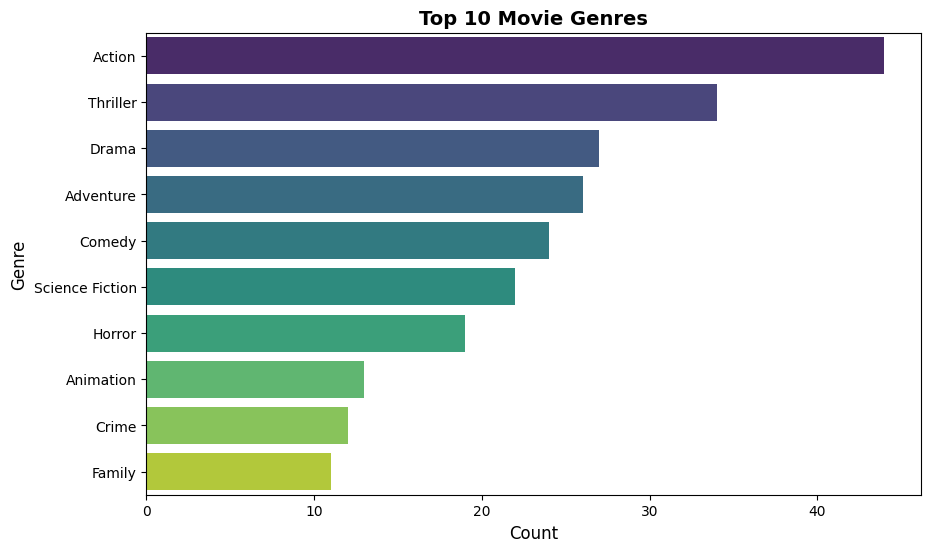

In [28]:
 #Plot 1: Genre Distribution
plt.figure(figsize=(10, 6))
genres = movies_df['genre'].str.split(', ').explode().dropna()
genres = genres.reset_index(drop=True)
sns.countplot(y=genres, order=genres.value_counts().index[:10], palette='viridis')
plt.title('Top 10 Movie Genres', fontsize=14, weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.show()
plt.close()

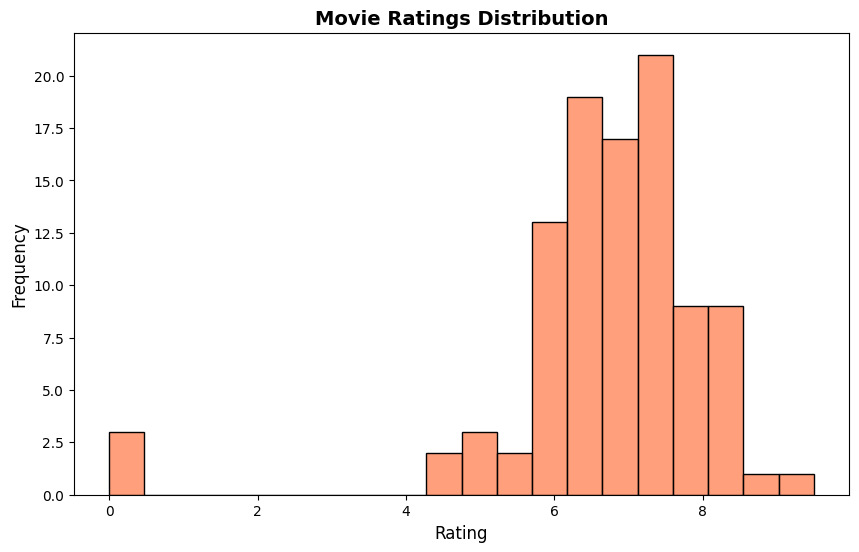

In [29]:
# Plot 2: Rating Distribution
plt.figure(figsize=(10, 6))
sns.histplot(movies_df['rating'].dropna(), bins=20, color='coral', edgecolor='black')
plt.title('Movie Ratings Distribution', fontsize=14, weight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()
plt.close()

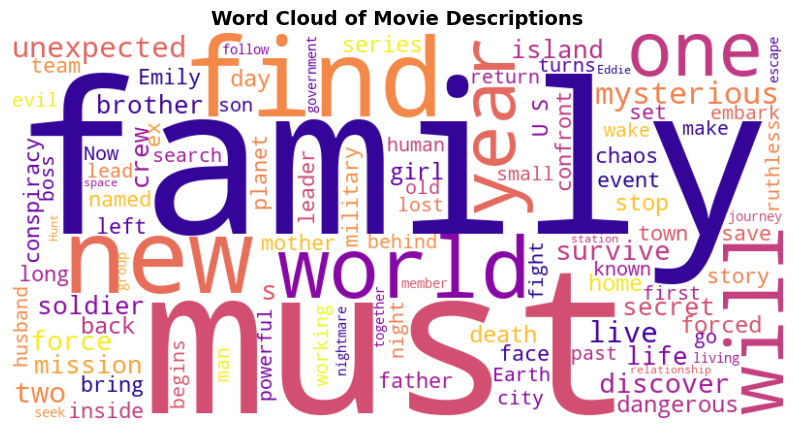

In [30]:
# Plot 3: Word Cloud for Descriptions
plt.figure(figsize=(10, 6))
text = ' '.join(movies_df['description'].dropna())
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white', colormap='plasma').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Descriptions', fontsize=14, weight='bold')
plt.show()
plt.close()

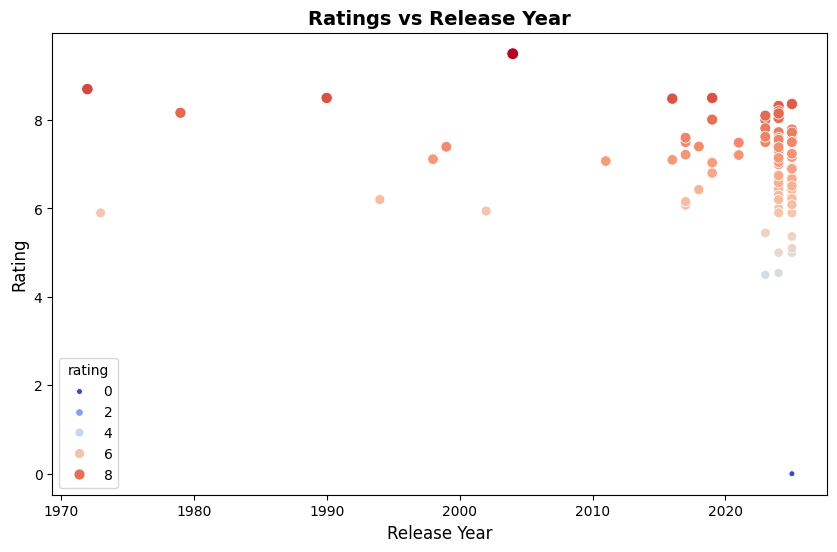

In [31]:
# Plot 4: Ratings vs Release Year
plt.figure(figsize=(10, 6))
movies_df['release_year'] = pd.to_numeric(movies_df['release_year'], errors='coerce')
sns.scatterplot(x='release_year', y='rating', data=movies_df.dropna(subset=['release_year', 'rating']), hue='rating', palette='coolwarm', size='rating')
plt.title('Ratings vs Release Year', fontsize=14, weight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()
plt.close()

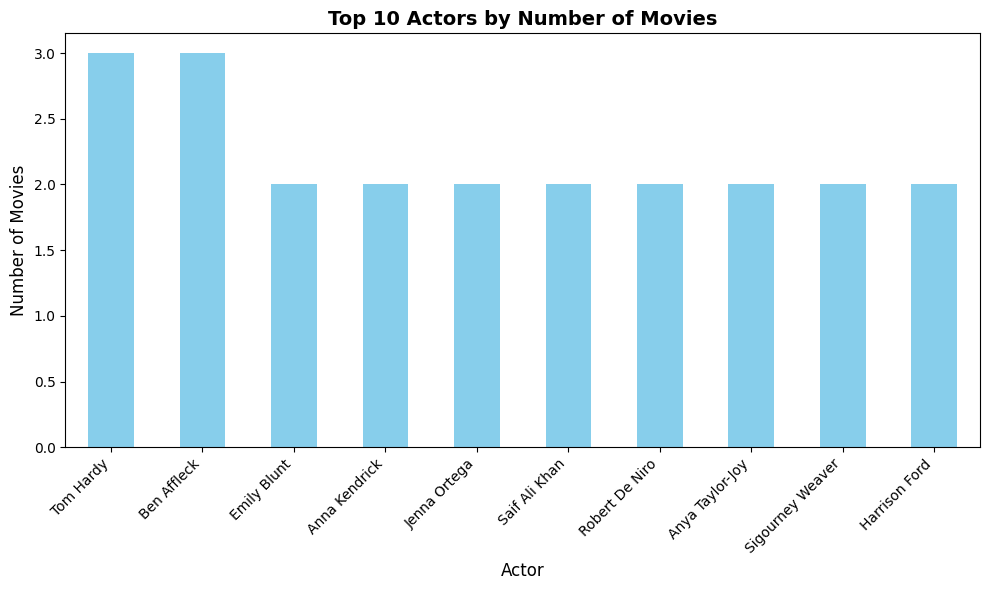

In [32]:
# Plot 6: Top Actors by Number of Movies
plt.figure(figsize=(10, 6))
actors_list = movies_df['actors'].str.split(', ', expand=True).stack().value_counts().head(10)
actors_list.plot(kind='bar', color='skyblue')
plt.title('Top 10 Actors by Number of Movies', fontsize=14, weight='bold')
plt.xlabel('Actor', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()


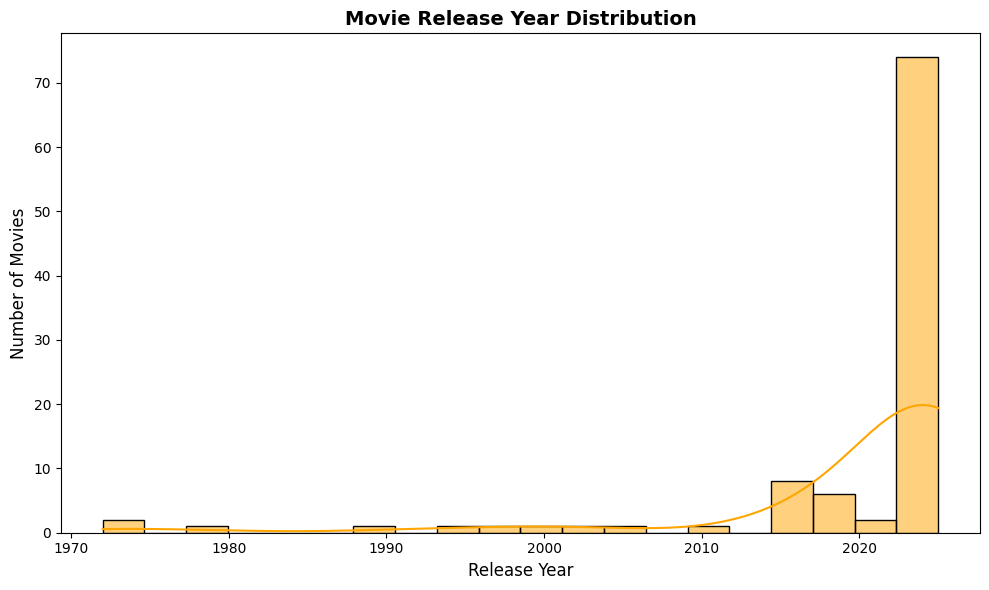

In [33]:
# Plot 8: Movie Release Year Distribution
plt.figure(figsize=(10, 6))
sns.histplot(movies_df['release_year'].dropna(), bins=20, kde=True, color='orange')
plt.title('Movie Release Year Distribution', fontsize=14, weight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

C:\Users\Elsayed Hassan\AppData\Local\Temp\ipykernel_7076\4108291674.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre', y='rating', data=genre_df, palette='Set2')


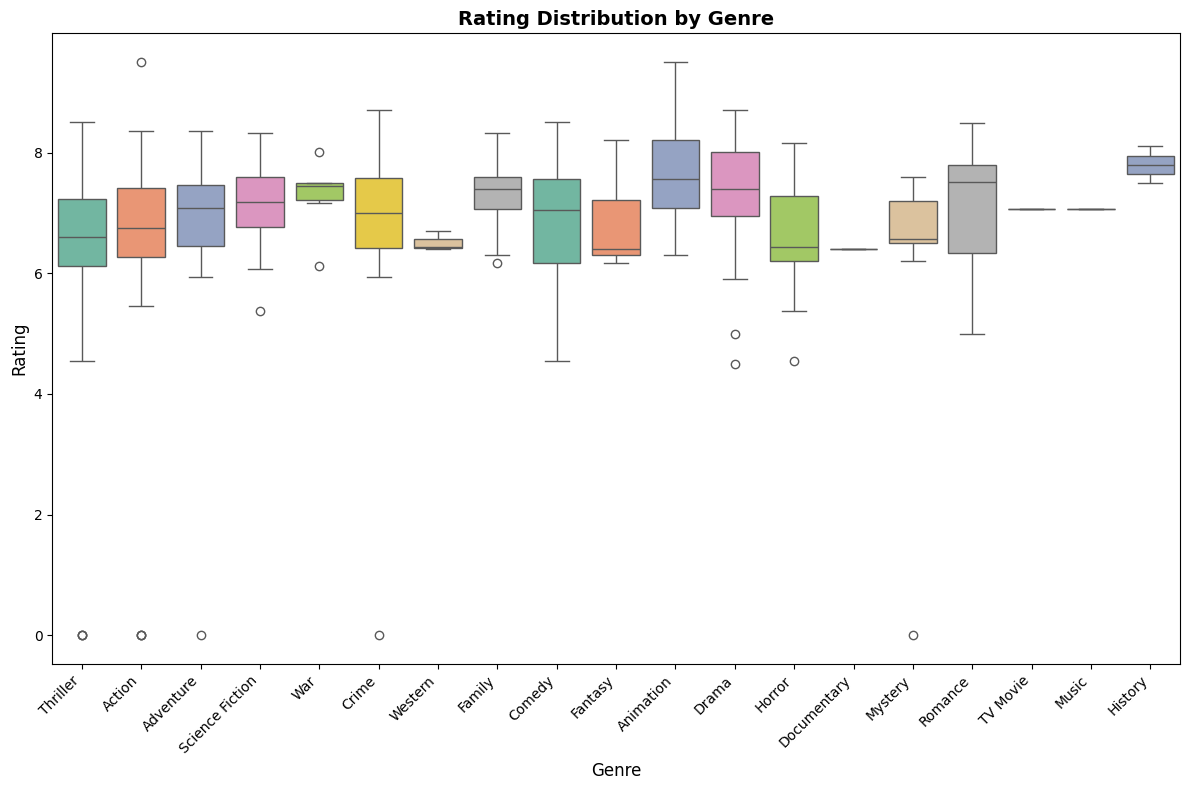

In [34]:
# Plot 9: Genre vs Rating
genre_df = movies_df.assign(genre=movies_df['genre'].str.split(', ')).explode('genre')
plt.figure(figsize=(12, 8))
sns.boxplot(x='genre', y='rating', data=genre_df, palette='Set2')
plt.title('Rating Distribution by Genre', fontsize=14, weight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()

In [35]:
# Part 2: Text Representation
def text_representation(df):
    stop_words = set(stopwords.words('english'))
    
    # Clean text
    def preprocess_text(text):
        if not isinstance(text, str):
            return ''
        tokens = word_tokenize(text.lower())
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        return ' '.join(tokens)
    
    df = df.copy()  # Create a copy to avoid modifying the original
    df['clean_description'] = df['description'].apply(preprocess_text)
    
    # Method 1: TF-IDF
    tfidf = TfidfVectorizer(max_features=5000)
    tfidf_matrix = tfidf.fit_transform(df['clean_description'])
    
    # Method 2: Word2Vec
    tokenized_descriptions = [word_tokenize(desc) for desc in df['clean_description'] if desc]
    w2v_model = Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=1, workers=4)
    def get_w2v_embedding(text):
        tokens = word_tokenize(text)
        vectors = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(100)
    df['w2v_embedding'] = df['clean_description'].apply(get_w2v_embedding)
    w2v_matrix = np.vstack(df['w2v_embedding'])
    
    # Method 3: Sentence Transformers
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    sbert_matrix = sbert_model.encode(df['clean_description'].tolist(), show_progress_bar=True)
    df['sbert_embedding'] = list(sbert_matrix)
    
    # Method 4: BERT Embeddings
    embedder = pipeline('feature-extraction', model='distilbert-base-uncased')
    def get_bert_embedding(text):
        if not text:
            return np.zeros(768)
        embedding = embedder(text, return_tensors=True)[0].mean(dim=0).numpy()
        return embedding
    df['bert_embedding'] = df['clean_description'].apply(get_bert_embedding)
    bert_matrix = np.vstack(df['bert_embedding'])
    
    return tfidf_matrix, w2v_matrix, sbert_matrix, bert_matrix, df

In [36]:
# Execute Text Representation
print("Processing text representations...")
tfidf_matrix, w2v_matrix, sbert_matrix, bert_matrix, movies_df = text_representation(movies_df)

Processing text representations...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [37]:
# Part 3: NLP-based Recommendation Model
class NLPRecommender:
    def __init__(self):
        self.df = None
        self.sbert_model = None
        self.sbert_matrix = None
        self.is_trained = False

    def train(self, df):
        """Train the model by generating SentenceTransformer embeddings for movie descriptions."""
        print("Training NLPRecommender model...")
        self.df = df.copy()
        
        # Preprocess text
        stop_words = set(stopwords.words('english'))
        def preprocess_text(text):
            if not isinstance(text, str):
                return ''
            tokens = word_tokenize(text.lower())
            tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
            return ' '.join(tokens)
        
        self.df['clean_description'] = self.df['description'].apply(preprocess_text)
        
        # Generate embeddings using SentenceTransformer
        self.sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.sbert_matrix = self.sbert_model.encode(self.df['clean_description'].tolist(), show_progress_bar=True)
        self.df['sbert_embedding'] = list(self.sbert_matrix)
        
        self.is_trained = True
        print("Training completed.")

    def recommend(self, movie_title, top_n=5, actor=None, min_rating=None, genre=None, age_rating=None):
        """Generate movie recommendations based on cosine similarity of embeddings."""
        if not self.is_trained:
            raise ValueError("Model is not trained. Call train() first.")
        
        if movie_title not in self.df['title'].values:
            return f"Movie '{movie_title}' not found."
        
        idx = self.df.index[self.df['title'] == movie_title][0]
        
        # Calculate cosine similarity
        sbert_sim = cosine_similarity(self.sbert_matrix[idx].reshape(1, -1), self.sbert_matrix).flatten()
        
        # Create similarity DataFrame
        sim_df = pd.DataFrame({'sim_score': sbert_sim}, index=self.df.index)
        sim_df = sim_df.join(self.df[['title', 'rating', 'genre', 'actors', 'age_rating', 'poster']])
        
        # Get input movie
        input_movie = sim_df.loc[[idx]][['title', 'rating', 'genre', 'actors', 'age_rating', 'poster', 'sim_score']]
        
        # Apply filters
        filtered_df = sim_df.drop(index=idx)
        if actor:
            filtered_df = filtered_df[filtered_df['actors'].str.contains(actor, case=False, na=False)]
        if min_rating:
            filtered_df = filtered_df[filtered_df['rating'] >= min_rating]
        if genre:
            filtered_df = filtered_df[filtered_df['genre'].str.contains(genre, case=False, na=False)]
        if age_rating:
            filtered_df = filtered_df[filtered_df['age_rating'].str.contains(age_rating, case=False, na=False)]
        
        # Sort and get top recommendations
        filtered_df = filtered_df.sort_values(by='sim_score', ascending=False)
        similar_movies = filtered_df.head(top_n-1)[['title', 'rating', 'genre', 'poster', 'sim_score']]
        
        recommendations = pd.concat([input_movie, similar_movies])
        recommendations = recommendations.sort_values(by='sim_score', ascending=False).head(top_n)
        recommendations = recommendations[['title', 'rating', 'genre', 'poster']]
        
        if recommendations.empty:
            return "No movies match the specified filters."
        
        return recommendations

    def evaluate(self, top_n=5):
        """Evaluate the model using diversity and coverage metrics."""
        if not self.is_trained:
            raise ValueError("Model is not trained. Call train() first.")
        
        print("Evaluating NLPRecommender model...")
        
        # Intra-list Diversity: Average pairwise cosine similarity within recommended lists
        diversity_scores = []
        for idx in self.df.index:
            sim_scores = cosine_similarity(self.sbert_matrix[idx].reshape(1, -1), self.sbert_matrix).flatten()
            sim_df = pd.DataFrame({'sim_score': sim_scores}, index=self.df.index)
            sim_df = sim_df.sort_values(by='sim_score', ascending=False).head(top_n)
            if len(sim_df) > 1:
                rec_matrix = self.sbert_matrix[sim_df.index]
                pairwise_sim = cosine_similarity(rec_matrix)
                # Exclude diagonal (self-similarity)
                mask = np.ones_like(pairwise_sim, dtype=bool)
                np.fill_diagonal(mask, False)
                avg_pairwise_sim = pairwise_sim[mask].mean() if pairwise_sim[mask].size > 0 else 1.0
                diversity_scores.append(1 - avg_pairwise_sim)  # Higher diversity = lower similarity
        
        avg_diversity = np.mean(diversity_scores) if diversity_scores else 0.0
        
        # Coverage: Percentage of movies that can be recommended
        recommended_movies = set()
        for idx in self.df.index:
            sim_scores = cosine_similarity(self.sbert_matrix[idx].reshape(1, -1), self.sbert_matrix).flatten()
            sim_df = pd.DataFrame({'sim_score': sim_scores}, index=self.df.index)
            recommended_movies.update(sim_df.sort_values(by='sim_score', ascending=False).head(top_n).index)
        coverage = len(recommended_movies) / len(self.df) * 100
        
        # Visualize similarity score distribution
        all_sim_scores = []
        for idx in self.df.index:
            sim_scores = cosine_similarity(self.sbert_matrix[idx].reshape(1, -1), self.sbert_matrix).flatten()
            all_sim_scores.extend(sim_scores[sim_scores < 1.0])  # Exclude self-similarity
        plt.figure(figsize=(10, 6))
        sns.histplot(all_sim_scores, bins=50, kde=True)
        plt.title('Distribution of Cosine Similarity Scores', fontsize=14, weight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.tight_layout()
        plt.savefig('similarity_distribution.png')
        plt.close()
        
        evaluation_results = {
            'avg_diversity': avg_diversity,
            'coverage': coverage,
            'n_movies': len(self.df)
        }
        
        print(f"Evaluation Results:")
        print(f"Average Intra-list Diversity: {avg_diversity:.4f} (higher is better)")
        print(f"Coverage: {coverage:.2f}% (percentage of movies recommended)")
        print(f"Total Movies: {evaluation_results['n_movies']}")
        
        return evaluation_results

In [38]:
# Initialize and Train the Model
print("Initializing and training NLPRecommender model...")
recommender = NLPRecommender()
recommender.train(movies_df)
recommender.evaluate()

Initializing and training NLPRecommender model...
Training NLPRecommender model...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Training completed.
Evaluating NLPRecommender model...
Evaluation Results:
Average Intra-list Diversity: 0.6680 (higher is better)
Coverage: 100.00% (percentage of movies recommended)
Total Movies: 100


{'avg_diversity': 0.6680103303492069, 'coverage': 100.0, 'n_movies': 100}

In [39]:
# Save the Model and Data as Pickle
print("Saving model and data as pickle files...")
with open('model.pkl', 'wb') as f:
    pickle.dump(recommender, f)
with open('movies_df.pkl', 'wb') as f:
    pickle.dump(movies_df, f)

Saving model and data as pickle files...


In [40]:
# Execute Recommendation
print("Generating recommendations for 'Alien' with filters...")
recommendations = recommender.recommend(
    movie_title="Alien",
    top_n=5,
    actor=None,
    min_rating=6,
    genre='Fiction',
    age_rating=None
)
print("\nCombined Recommendations for 'Alien' (With Filters):")
print(recommendations)

Generating recommendations for 'Alien' with filters...

Combined Recommendations for 'Alien' (With Filters):
                                                title  rating  \
40                                              Alien   8.164   
62                                    Alien: Covenant   6.155   
64                                          Free Fall   7.500   
93                                       Annihilation   6.426   
53  Phineas and Ferb The Movie: Across the 2nd Dim...   7.072   

                                                genre  \
40                            Horror, Science Fiction   
62                  Science Fiction, Horror, Thriller   
64                          Thriller, Science Fiction   
93                            Science Fiction, Horror   
53  Animation, Comedy, Family, TV Movie, Science F...   

                                               poster  
40  https://image.tmdb.org/t/p/w500/vfrQk5IPloGg1v...  
62  https://image.tmdb.org/t/p/w500/zecMELPbU

In [41]:
# Evaluate the Model
print("\nEvaluating the model...")
evaluation_results = recommender.evaluate(top_n=5)


Evaluating the model...
Evaluating NLPRecommender model...
Evaluation Results:
Average Intra-list Diversity: 0.6680 (higher is better)
Coverage: 100.00% (percentage of movies recommended)
Total Movies: 100


In [ ]:
'C:/Users/Elsayed Hassan/NLP_Project/model.pkl'